Установка необходимых библиотек

In [ ]:
! pip install pygsheets
! pip3 install --upgrade google-api-python-client
! pip3 install oauth2client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Подключение необходимых библиотек и к google drive

In [ ]:
import pandas as pd
import random
import gspread
import pygsheets
import httplib2 
import apiclient.discovery
from oauth2client.service_account import ServiceAccountCredentials
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Настройка и подключение к скопированной странице с исходными данными

https://docs.google.com/spreadsheets/d/1DnycTUGsNGX8Ah89dys9tJMIyIYo_4yJV1_RL5Zc0NI/edit#gid=1439079331

In [ ]:
CREDENTIALS_FILE = '/content/voltaic-phalanx-318901-4e02d505da4f.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(CREDENTIALS_FILE, ['https://www.googleapis.com/auth/spreadsheets', 'https://www.googleapis.com/auth/drive'])
httpAuth = credentials.authorize(httplib2.Http())
service = apiclient.discovery.build('sheets', 'v4', http = httpAuth)
spreadsheetId = ['1DnycTUGsNGX8Ah89dys9tJMIyIYo_4yJV1_RL5Zc0NI', '1Rcq_EsAuqS85XIuWL-kENc3HjgY1icZMY_t4_3FqAOM']
ranges = ["A1:H230"] 
          
results = service.spreadsheets().values().batchGet(spreadsheetId = spreadsheetId[0], 
                                     ranges = ranges, 
                                     valueRenderOption = 'FORMATTED_VALUE',  
                                     dateTimeRenderOption = 'FORMATTED_STRING').execute() 
sheet_values = results['valueRanges'][0]['values']

Преобразование полученных данных в DataFrame

In [ ]:
df = pd.DataFrame(sheet_values[1:], columns =sheet_values[0])
df = df.dropna()
df.head()

,area,cluster,cluster_name,keyword,good (1),count,x,y
0,eligibility,0,Кластер 0,several animated buried,1,1260,5.772341707768705,12.564796257345005
1,eligibility,0,Кластер 0,singles unusual buyers,1,866,14.829279864186246,7.8507285727125815
2,eligibility,0,Кластер 0,hawaiian directive,1,163,11.381855832287469,3.8981370219558604
3,eligibility,0,Кластер 0,dynamics directly,1,1146,9.980149264692514,6.281427914064545
4,eligibility,1,Кластер 1,decision surgeons montreal,1,823,3.2839396214346106,4.39674063521296


Удаление лишних столбцов (он оказался один)

In [ ]:
del df['good (1)']
df.head()

,area,cluster,cluster_name,keyword,count,x,y
0,eligibility,0,Кластер 0,several animated buried,1260,5.772341707768705,12.564796257345005
1,eligibility,0,Кластер 0,singles unusual buyers,866,14.829279864186246,7.8507285727125815
2,eligibility,0,Кластер 0,hawaiian directive,163,11.381855832287469,3.8981370219558604
3,eligibility,0,Кластер 0,dynamics directly,1146,9.980149264692514,6.281427914064545
4,eligibility,1,Кластер 1,decision surgeons montreal,823,3.2839396214346106,4.39674063521296


Удаление тех строк, в которых невозможно конвертировать cluster, count, x, y в число

In [ ]:
row_errors = []
for i in range(len(df['x'])):
    try:
        pd.to_numeric(df['cluster'].values[i])
        pd.to_numeric(df['count'].values[i])
        pd.to_numeric(df['x'].values[i])
        pd.to_numeric(df['y'].values[i])
    except:
        row_errors.append(i)
df = df.drop(index=row_errors)

Поиск дубликатов из одной области (таких не оказалось)

In [ ]:
keyword_list = []
current_area = ''
row_delete = []
for i, row in df.iterrows():
    if current_area != row.area:
        current_area = row.area
        keyword_list = []
    if row.keyword in keyword_list:
        row_delete.append(i)
row_delete

[]

Создаем дубликат DataFrame, в котором удаляем повторы кластеров в одной и той же области. Это потребуется для более быстрой работы по определению цветов

In [ ]:
test = df.copy()
test = test.drop_duplicates(['area', 'cluster'])
test.head()

,area,cluster,cluster_name,keyword,count,x,y
0,eligibility,0,Кластер 0,several animated buried,1260,5.772341707768705,12.564796257345005
4,eligibility,1,Кластер 1,decision surgeons montreal,823,3.2839396214346106,4.39674063521296
9,eligibility,2,Кластер 2,vampire injured,139,5.247682515198207,0.7791614555083071
13,eligibility,3,Кластер 3,creativity bloggers,1817,13.893232193861433,2.5133519530949426
16,capability,0,Кластер 0,tunnel lyrics,1013,14.182495753536584,11.241094130877395


Генерируем рандомный цвет в rgb формате

После этого присваиваем словосочетанию рандомный индекс от 0 до 19 (номер цвета colors). Если цвет уже встречался в этой области, присваиваем новый и повторяем проверку.

In [ ]:
colors = []
for i in range(20):
    r, g, b = random.random(), random.random(), random.random()
    while (r, g, b) in colors:
        r, g, b = random.random(), random.random(), random.random()
    colors.append((r, g, b))


color_distr = {}
prev = []
for i, row in test.iterrows():
    rand_color_ind = random.randint(0, 19)
    if row.area not in prev:
        color_distr[row.area, row.cluster] = rand_color_ind
        prev.append(row.area)
    else:
        check = True
        while check:
            for key, value in color_distr.items():
                if key[0] == row.area and rand_color_ind == value:
                    rand_color_ind = random.randint(0, 19)
                    break
            else:
                check = False
        color_distr[row.area, row.cluster] = rand_color_ind
color_distr

{('eligibility', '0'): 2,
 ('eligibility', '1'): 0,
 ('eligibility', '2'): 6,
 ('eligibility', '3'): 18,
 ('capability', '0'): 17,
 ('capability', '1'): 19,
 ('capability', '2'): 4,
 ('capability', '3'): 11,
 ('available', '0'): 9,
 ('available', '1'): 2,
 ('available', '2'): 18,
 ('available', '3'): 6,
 ('protein', '0'): 1,
 ('protein', '1'): 9,
 ('protein', '2'): 2,
 ('protein', '3'): 19,
 ('winner', '0'): 11,
 ('winner', '1'): 8,
 ('winner', '2'): 0,
 ('winner', '3'): 4,
 ('locator', '0'): 10,
 ('locator', '1'): 18,
 ('locator', '2'): 14,
 ('locator', '3'): 15,
 ('worlds', '0'): 16,
 ('worlds', '1'): 13,
 ('worlds', '2'): 3,
 ('worlds', '3'): 0,
 ('ar\\vr', '0'): 18,
 ('ar\\vr', '1'): 6,
 ('ar\\vr', '2'): 11,
 ('ar\\vr', '3'): 1,
 ('twisted', '0'): 2,
 ('twisted', '1'): 3,
 ('twisted', '2'): 6,
 ('twisted', '3'): 19,
 ('lithuania', '0'): 14,
 ('lithuania', '1'): 10,
 ('lithuania', '2'): 18,
 ('lithuania', '3'): 7,
 ('personnel', '0'): 10,
 ('personnel', '1'): 15,
 ('personnel', '2')

И благодаря полученному словарю присваиваем каждому словосочетанию соответствующий цвет по области и кластеру

In [ ]:
res = []
for i, row in df.iterrows():
    res.append(colors[color_distr[row.area, row.cluster]])
df['color'] = res
df.head()

,area,cluster,cluster_name,keyword,count,x,y,color
0,eligibility,0,Кластер 0,several animated buried,1260,5.772341707768705,12.564796257345005,"(0.19504252040589387, 0.26575792185884994, 0.0..."
1,eligibility,0,Кластер 0,singles unusual buyers,866,14.829279864186246,7.8507285727125815,"(0.19504252040589387, 0.26575792185884994, 0.0..."
2,eligibility,0,Кластер 0,hawaiian directive,163,11.381855832287469,3.8981370219558604,"(0.19504252040589387, 0.26575792185884994, 0.0..."
3,eligibility,0,Кластер 0,dynamics directly,1146,9.980149264692514,6.281427914064545,"(0.19504252040589387, 0.26575792185884994, 0.0..."
4,eligibility,1,Кластер 1,decision surgeons montreal,823,3.2839396214346106,4.39674063521296,"(0.37426890717824135, 0.29637052604602443, 0.6..."


Сортируем данные

In [ ]:
df = df.sort_values('area cluster cluster_name count'.split(), ascending=[True, True, True, False])

Запись DataFrame в google spreadsheet

In [ ]:
def write_to_gsheet(service_file_path, spreadsheet_id, sheet_name, data_df):
    gc = pygsheets.authorize(service_file=service_file_path)
    sh = gc.open_by_key(spreadsheet_id)
    try:
        sh.add_worksheet(sheet_name)
    except:
        pass
    wks_write = sh.worksheet_by_title(sheet_name)
    wks_write.clear('A1',None,'*')
    wks_write.set_dataframe(data_df, (1,1), encoding='utf-8', fit=True)
    wks_write.frozen_rows = 1

In [ ]:
write_to_gsheet(CREDENTIALS_FILE, spreadsheetId[1], 'Лист1',df)

Подключение фильтров к таблице

In [ ]:
request_body = {
    'requests': [
        {
            'setBasicFilter': {
                'filter': {
                    'range': {
                        'sheetId': 0,
                        'startRowIndex': 0,
                        'startColumnIndex': 0 
                    },
                }
            }
        }
    ]
}

response = service.spreadsheets().batchUpdate(
    spreadsheetId=spreadsheetId[1],
    body=request_body
).execute()

Данные записаны в 

https://docs.google.com/spreadsheets/d/1Rcq_EsAuqS85XIuWL-kENc3HjgY1icZMY_t4_3FqAOM/edit#gid=0

## 2


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
t = pd.unique(df['area'])

Обход наложения подписей:

Определяем, расположены ли рядом другие точки. Если да, то для нижней точки выводим подпись снизу. Также определяем самую вверхнюю точку (на этих данных проблемы возникали только с ней) и также выводим данные снизу. Другие точки никак не налезают на границы графика

In [ ]:
def plot_graph(df, filter, footer):
    df = df[df['area'] == filter]
    plt.figure(figsize=(1500 / 96, 1500 / 96))
    plt.title(footer)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.scatter(x = pd.to_numeric(df['x']), y = pd.to_numeric(df['y']), c = df['color'], linewidths = 2, edgecolors = 'black', s = 100)

    x, y, res = df['x'], df['y'], {}
    upper = 0, -10e8
    for i in range(len(x)):
        for j in range(i + 1, len(x)):
            x1, y1 = pd.to_numeric(df['x'].values[i]), pd.to_numeric(df['y'].values[i])
            x2, y2 = pd.to_numeric(df['x'].values[j]), pd.to_numeric(df['y'].values[j])
            length = ((x1 - x2)**2 + (y1 - y2)**2)**0.5

            if upper[1] < y1:
                upper = x1, y1
            elif upper[1] < y2:
                upper = x2, y2

            if length > 1:
                continue
            if y1 > y2:
                res[x2, y2] = 'd'
            else:
                res[x1, y1] = 'd'
    res[upper] = 'd'
    for i in pd.unique(df['keyword']):
        for j in range(len(df[df['keyword']==i])):
            offset = max(map(len, i.split(' ')))
            x = pd.to_numeric(df[df['keyword']==i]['x'].values[j])
            y = pd.to_numeric(df[df['keyword']==i]['y'].values[j])
            if res.get((x, y)) is None:
                plt.annotate(i.strip().replace(' ', '\n'), xy=(
                    x - offset / 20, 
                    y + 0.15))
            else:
                plt.annotate(i.strip().replace(' ', '\n'), xy=(
                    x - offset / 20, 
                    y - len(i.split()) * 0.21))
    plt.savefig(f'{footer}.png')
    plt.show()

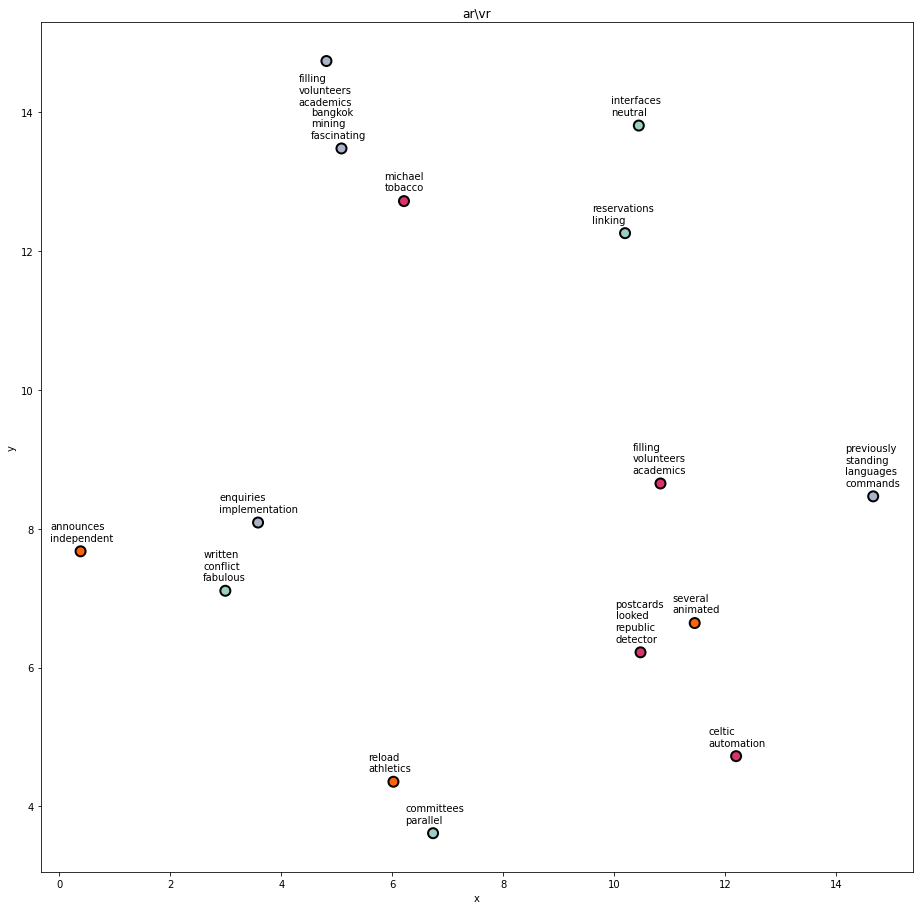

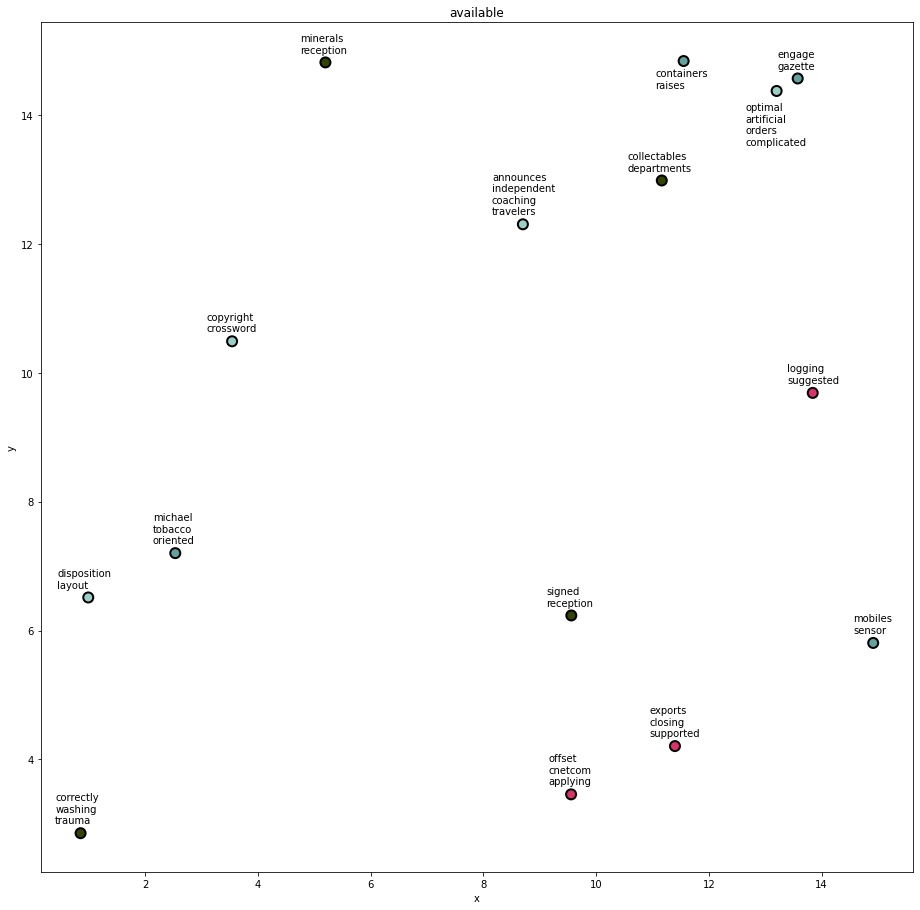

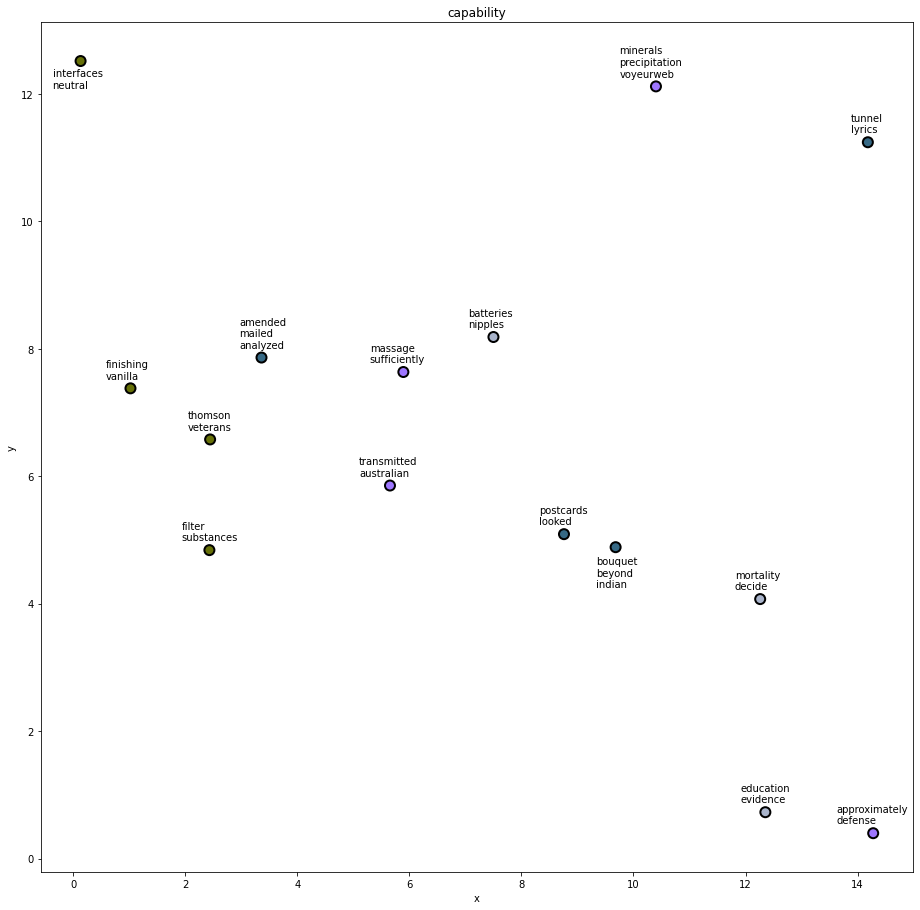

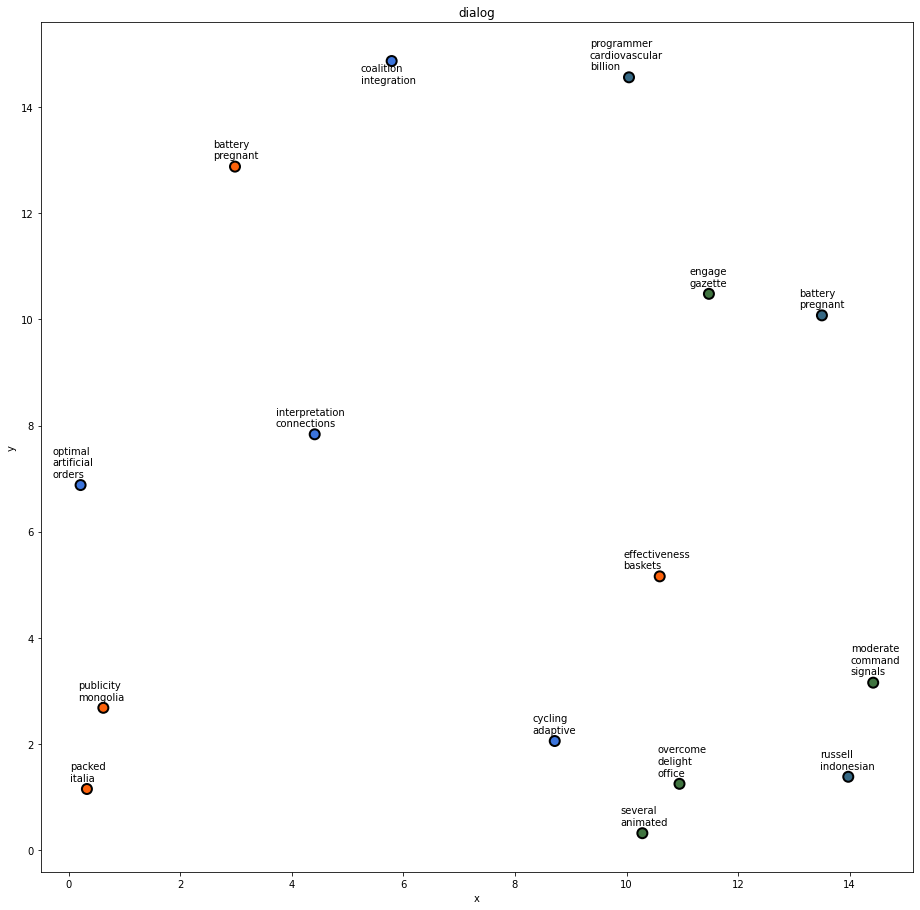

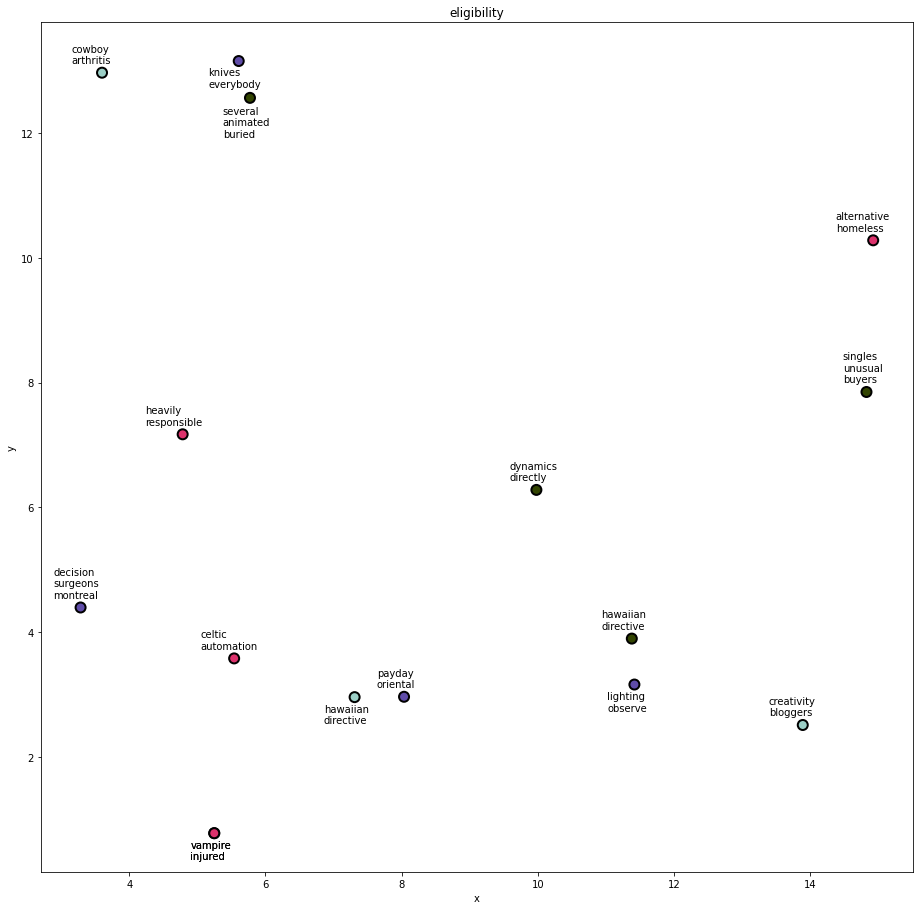

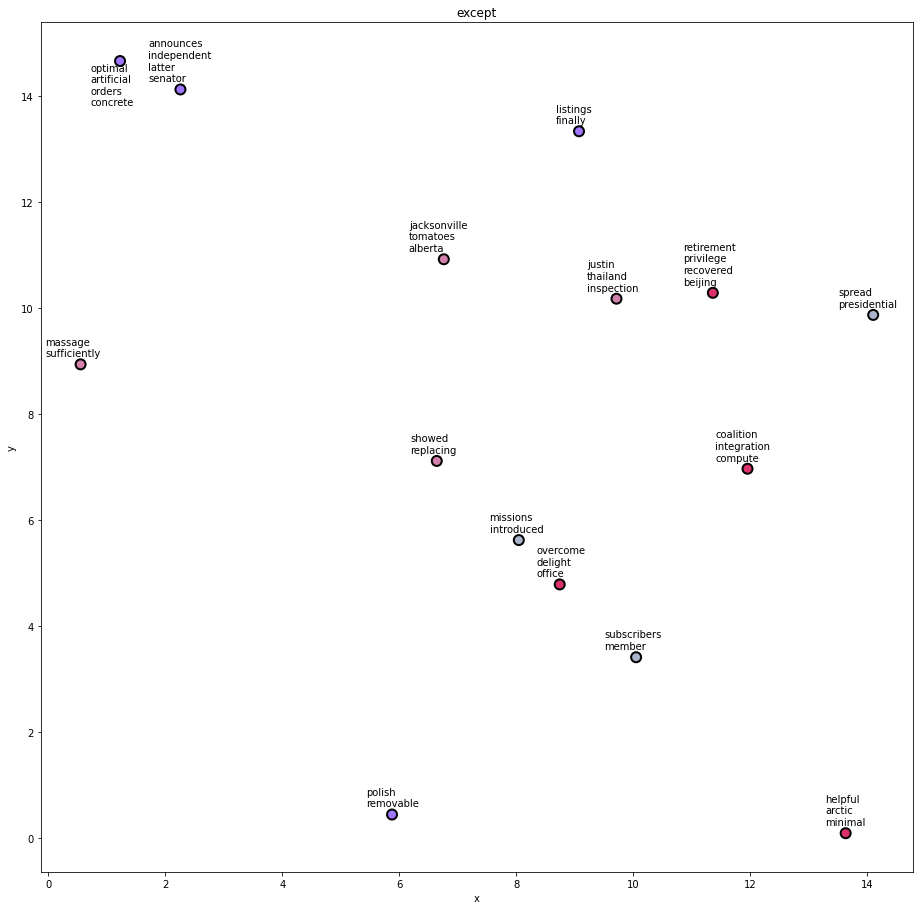

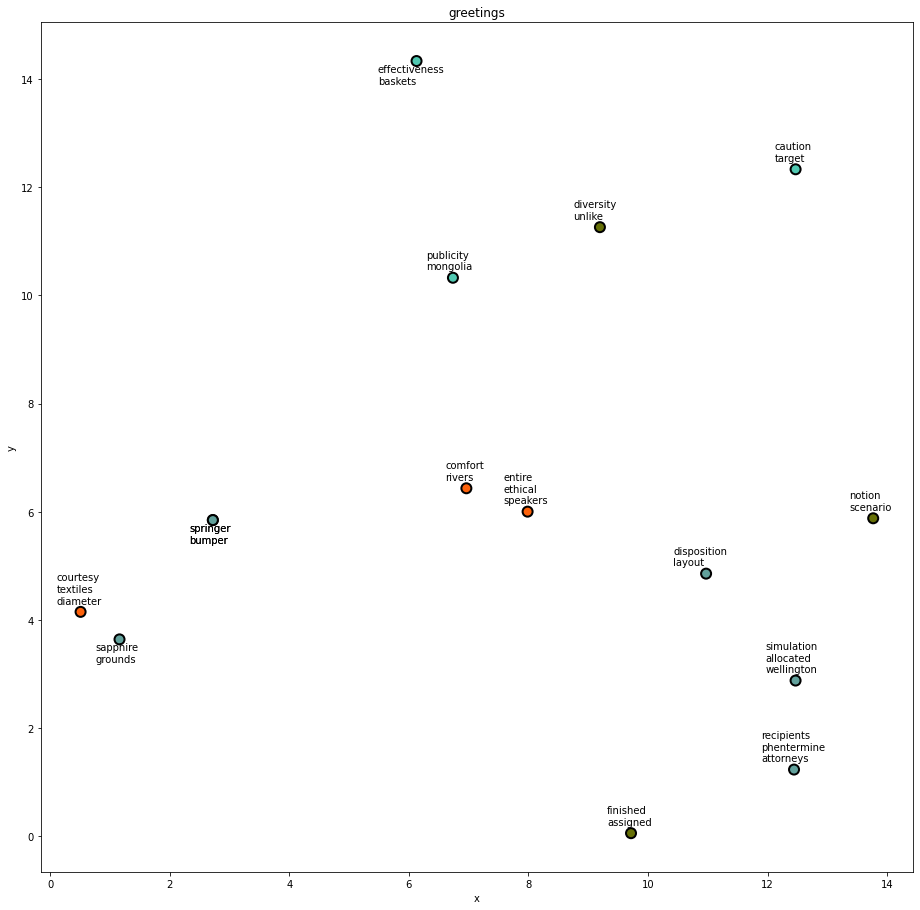

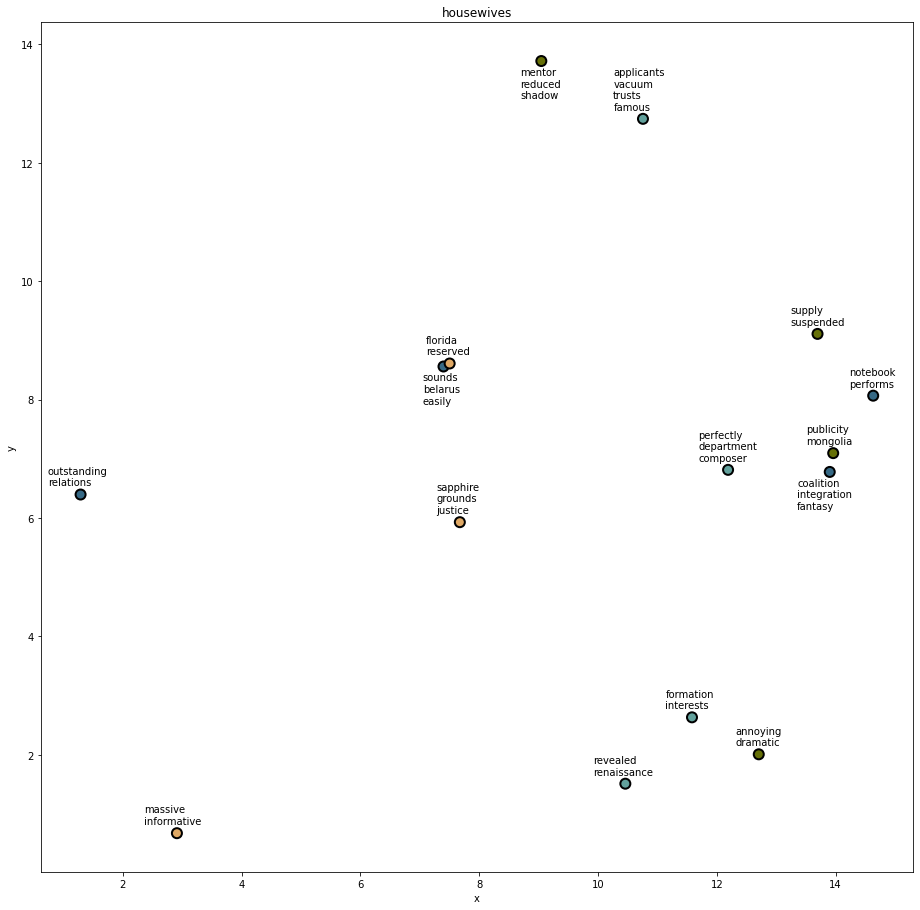

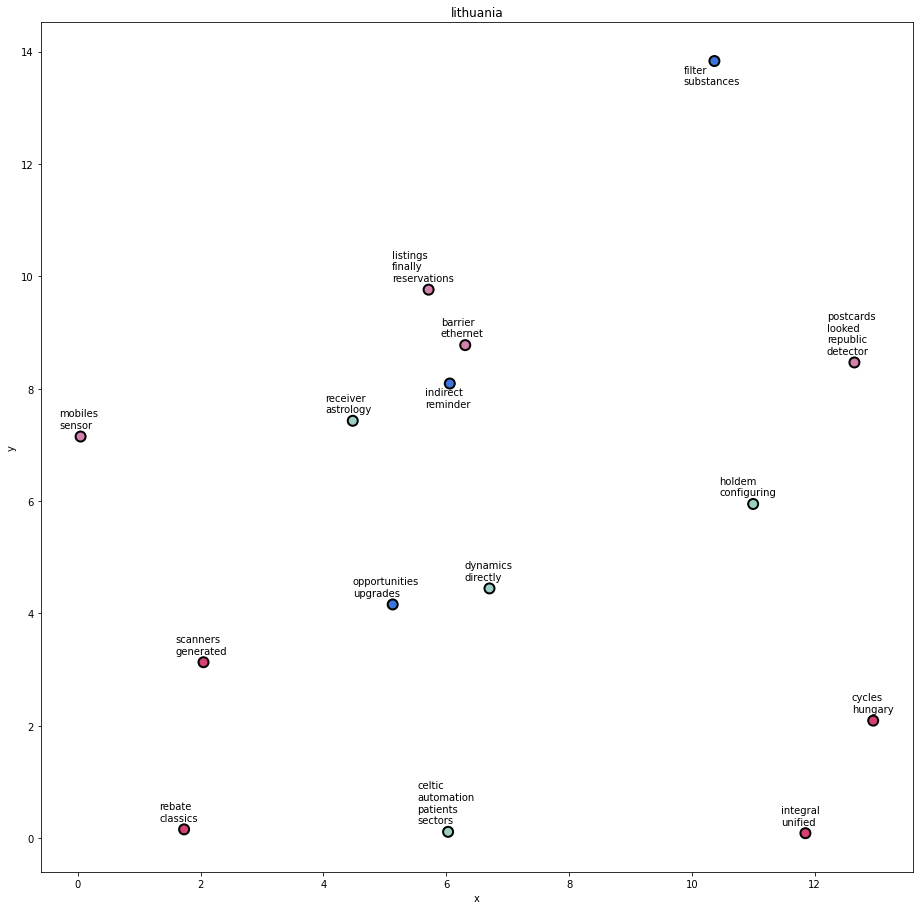

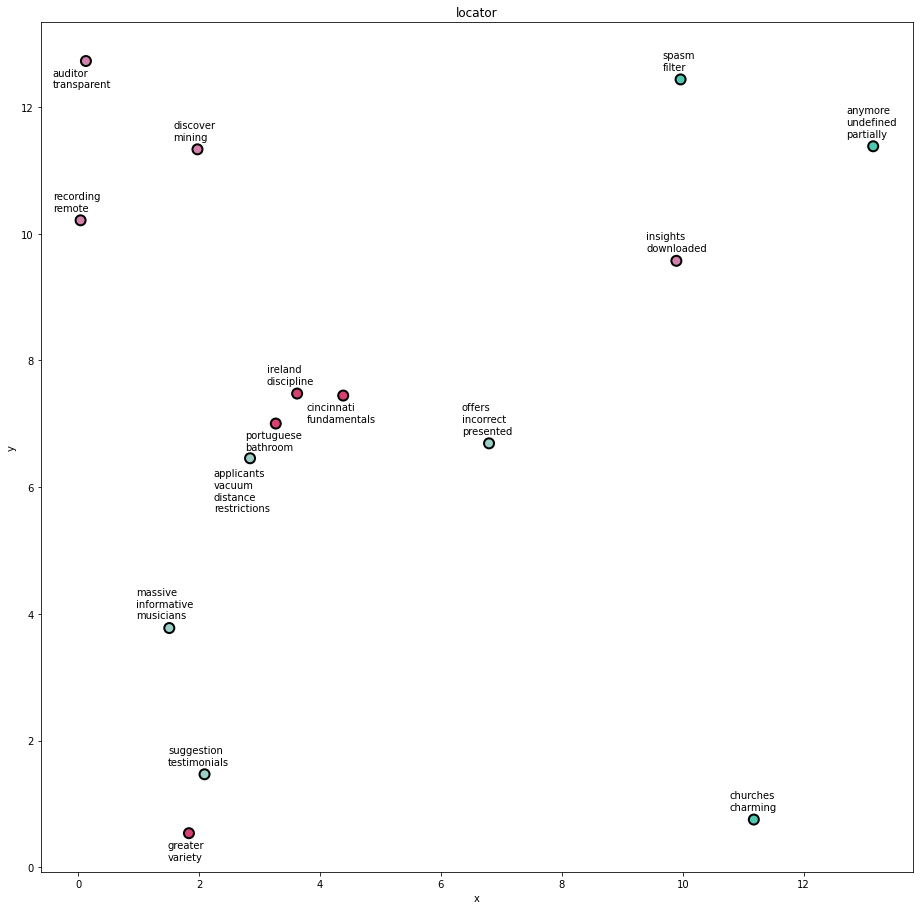

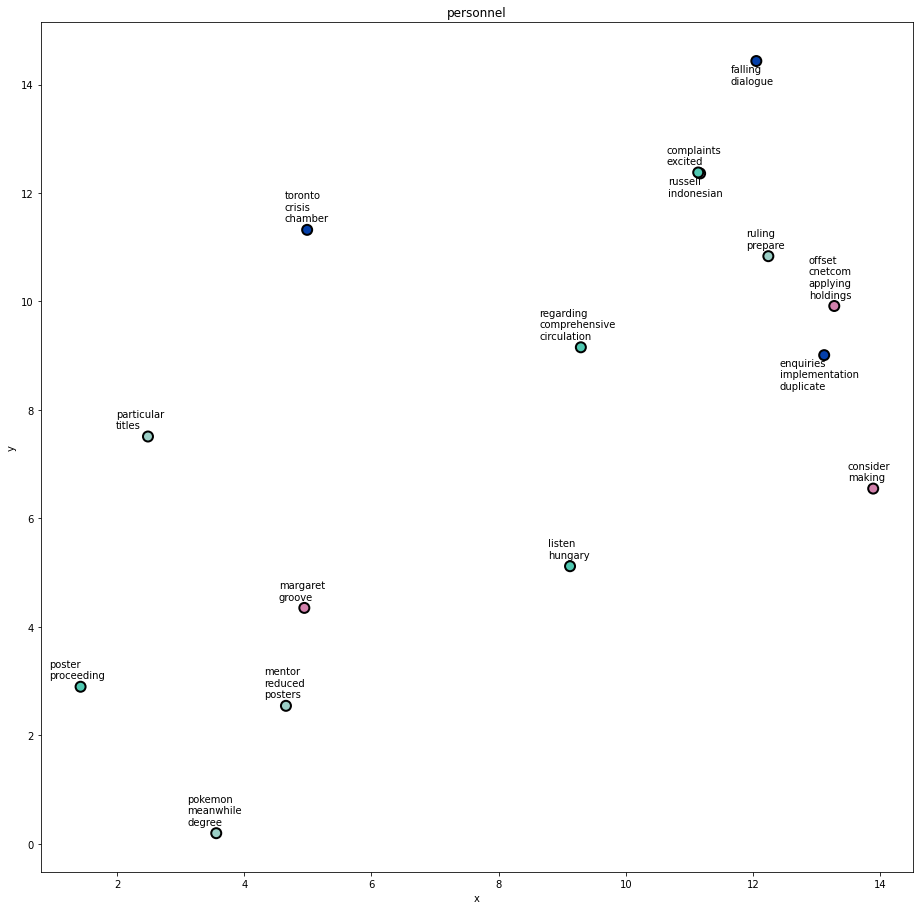

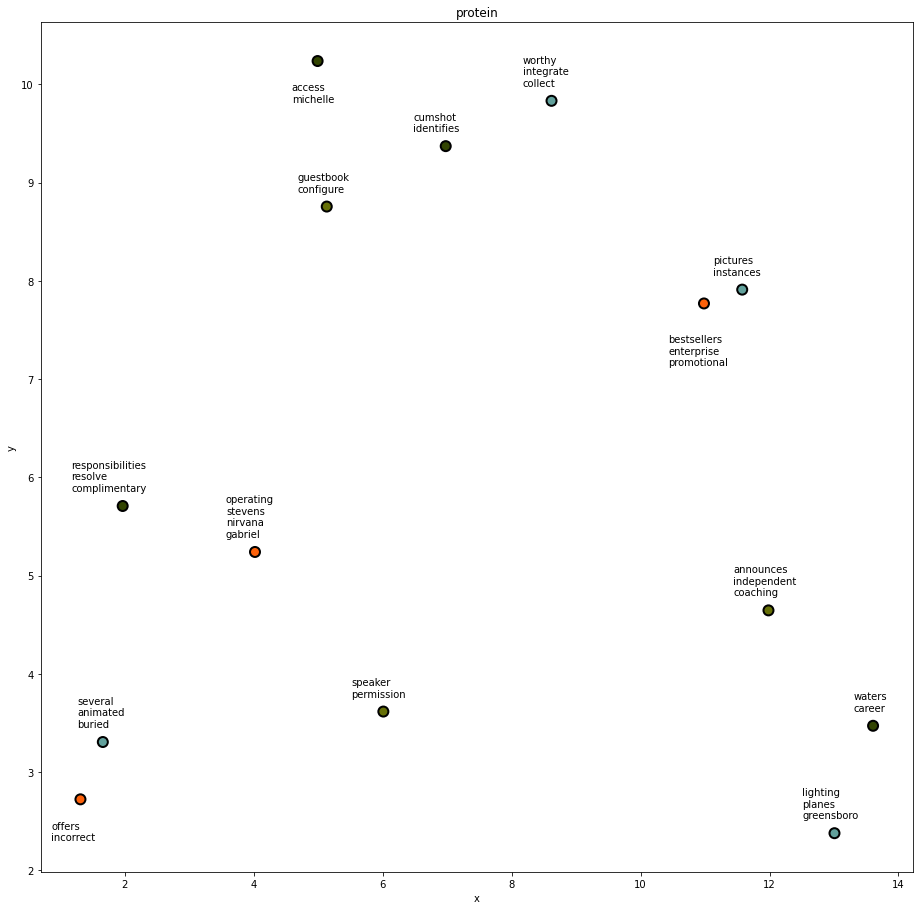

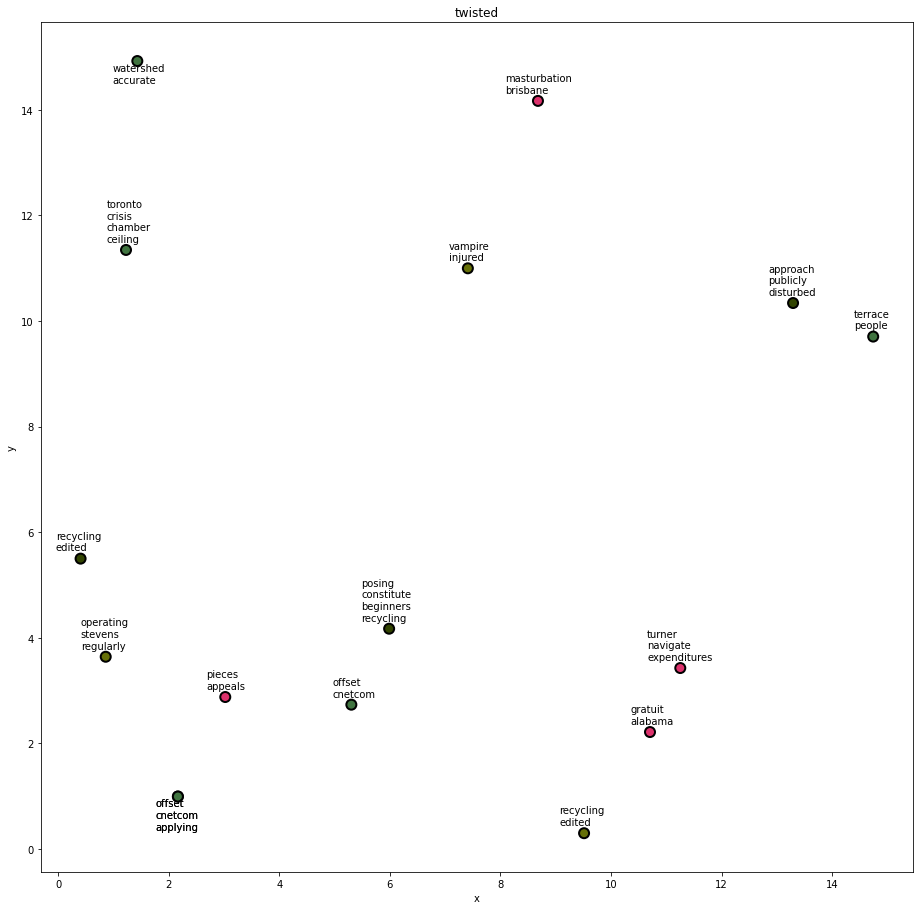

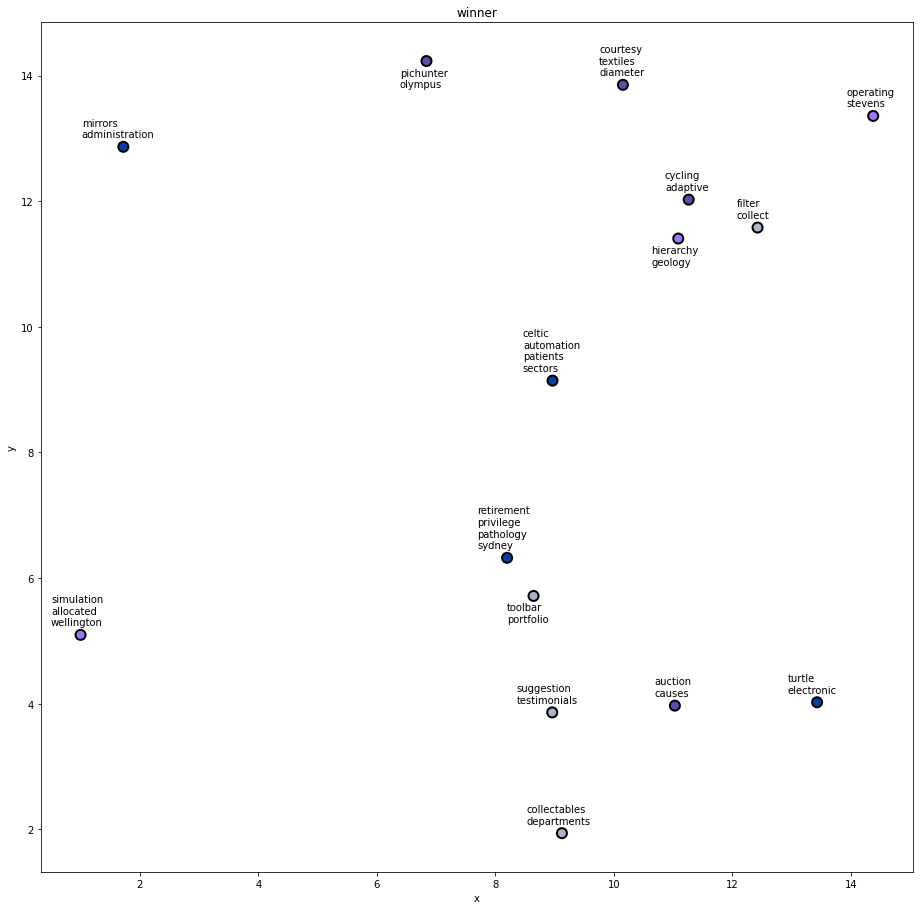

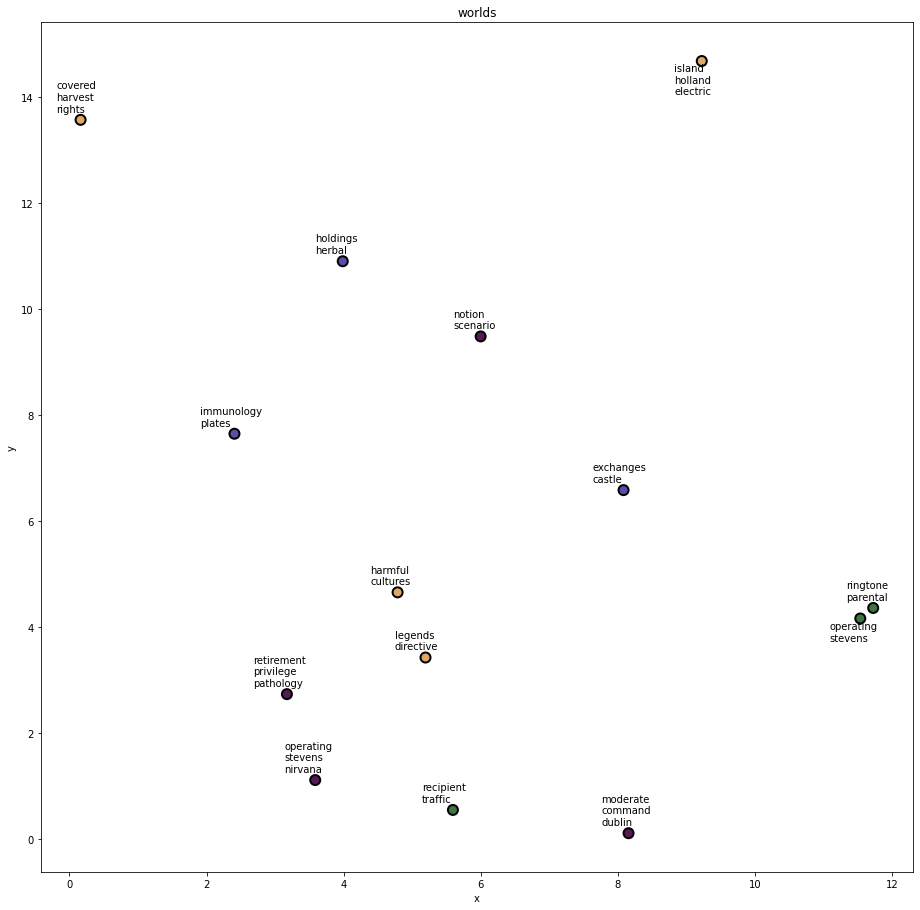

In [ ]:
for i in t:
    plot_graph(df, i, i)